In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None)

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, classification_report

# Read in Data

In [4]:
full_df = pd.read_pickle("full_clean_df.pkl")
full_df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'health_insurance_0.0', 'health_insurance_1.0',
       'health_insurance_nan', 'doctor_recc_h1n1_0.0', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_nan', 'doctor_recc_seasonal_0.0',
       'doctor_recc_seasonal_1.0', 'doctor_recc_seasonal_nan',
       'income_poverty_<= $75,000, Above Poverty', 'income_poverty_> $75,000',
       'income_poverty_

In [5]:
full_df.rename(columns={'income_poverty_<= $75,000, Above Poverty': 'income_poverty_less $75,000, Above Poverty',
                        'income_poverty_> $75,000': 'income_poverty_greater $75,000'}, inplace=True)
#full_df.columns



In [6]:
all_resp = full_df.shape[0]
all_resp

24280

### split the data

In [7]:
# remove the holdeout
full_df, ho_df = train_test_split(
    full_df,
    test_size=0.2,
    shuffle=True,
    random_state=100
)

In [8]:
important_features = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
            'opinion_h1n1_sick_from_vacc','health_insurance_1.0', 'health_insurance_0.0', 'health_insurance_nan', 
            'doctor_recc_h1n1_1.0', 'doctor_recc_h1n1_nan', 'doctor_recc_seasonal_0.0',]

features_df = full_df.drop(labels=['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis = 1)
h1n1_target = full_df['h1n1_vaccine']
seasonal_target = full_df['seasonal_vaccine']
combined_targets = full_df[['h1n1_vaccine', 'seasonal_vaccine']]

# set up the algorithms

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [10]:
# function to plot a single ROC curve 
def plot_roc(y_true, y_score, label_name, ax):
    """
    takes in a y actual, y estimate, a label and a plt ax
    Plots an roc curve on the give ax
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

In [11]:
logistic_regression = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('estimator', LogisticRegression(penalty="l2", C=1))
])

knn_pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors=5))
])

xgb = XGBClassifier()
rfc = RandomForestClassifier()
svc = SVC(probability=True)
gnb = GaussianNB()
comnb = ComplementNB()
catnb = CategoricalNB()

classifier_list = [(logistic_regression, 'Logistic'), (knn_pipeline, 'Nearest Neighbor'), 
                   (rfc, 'Random Forest'), (xgb, 'XGB'), (svc, 'SVC'), (gnb, "Gaussian NB"), 
                   (comnb, "Compement NB"), (catnb, "Categorical NB")]

In [12]:
def plot_classifier_rocs(X_train, X_eval, y_train, y_eval, classifier_list):
    """
    a function that wll plot multiple rocs
    takes in a train and eval set of x and ys, and a list of classifiers
    spits out a bunch of roc plots
    """
    fig, ax = plt.subplots(
        len(classifier_list), 1, figsize=(9,len(classifier_list)*9)
    )

    for i, c_tup in enumerate(classifier_list):
        if len(classifier_list) == 1:
            ax_curr=ax
        else:
            ax_curr=ax[i]
        c = c_tup[0] 
        c.fit(X_train, y_train)
        preds = c.predict_proba(X_eval)
        plot_roc(
            y_eval, 
            preds[:, 1], 
            c_tup[1],
            ax=ax_curr
        )

# Plot ROC for H1N1

In [13]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
)    

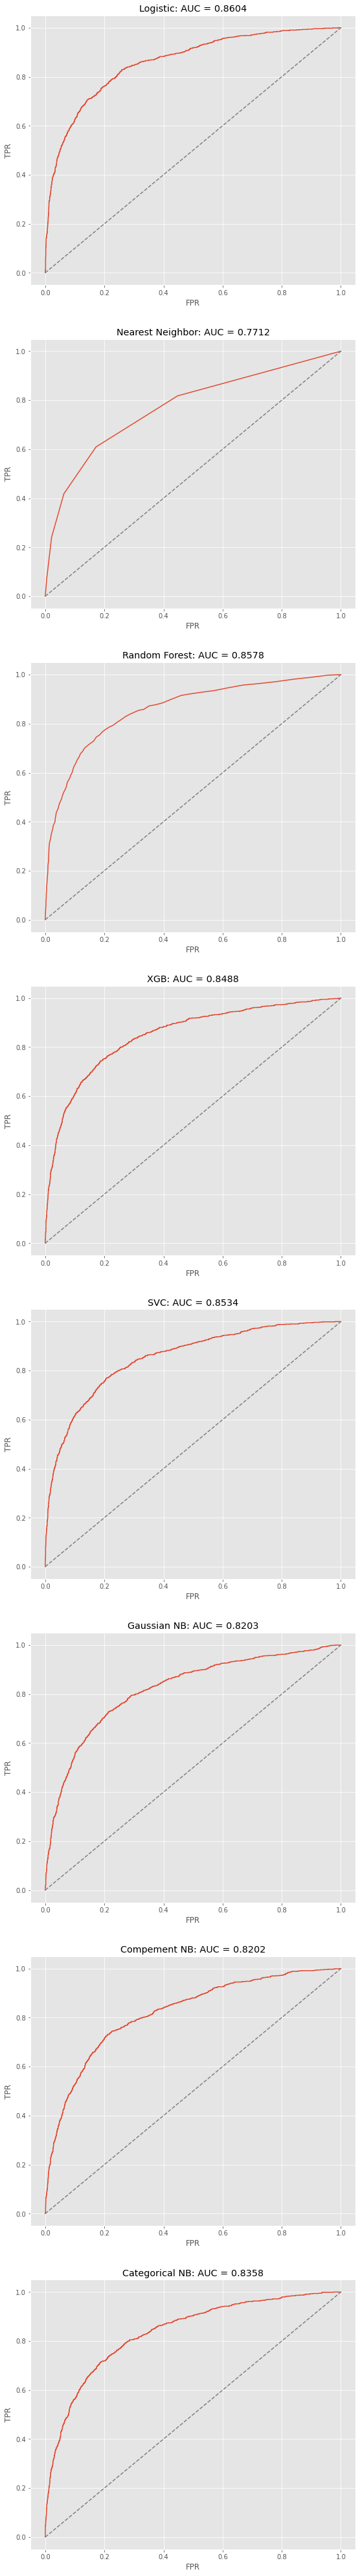

In [14]:
plot_classifier_rocs(X_train, X_eval, y_train, y_eval, classifier_list)

So wehen checking out the ROC score, it looks like in the first go through that Logistic, RF, XGB, and SVC (the tree based and linear based models) out preformed KNN and the Naive Bayes models when looking at the H1N1 target. 

Time to look athe the Seasonal Target.

# Plot ROC for Seasonal

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
)  

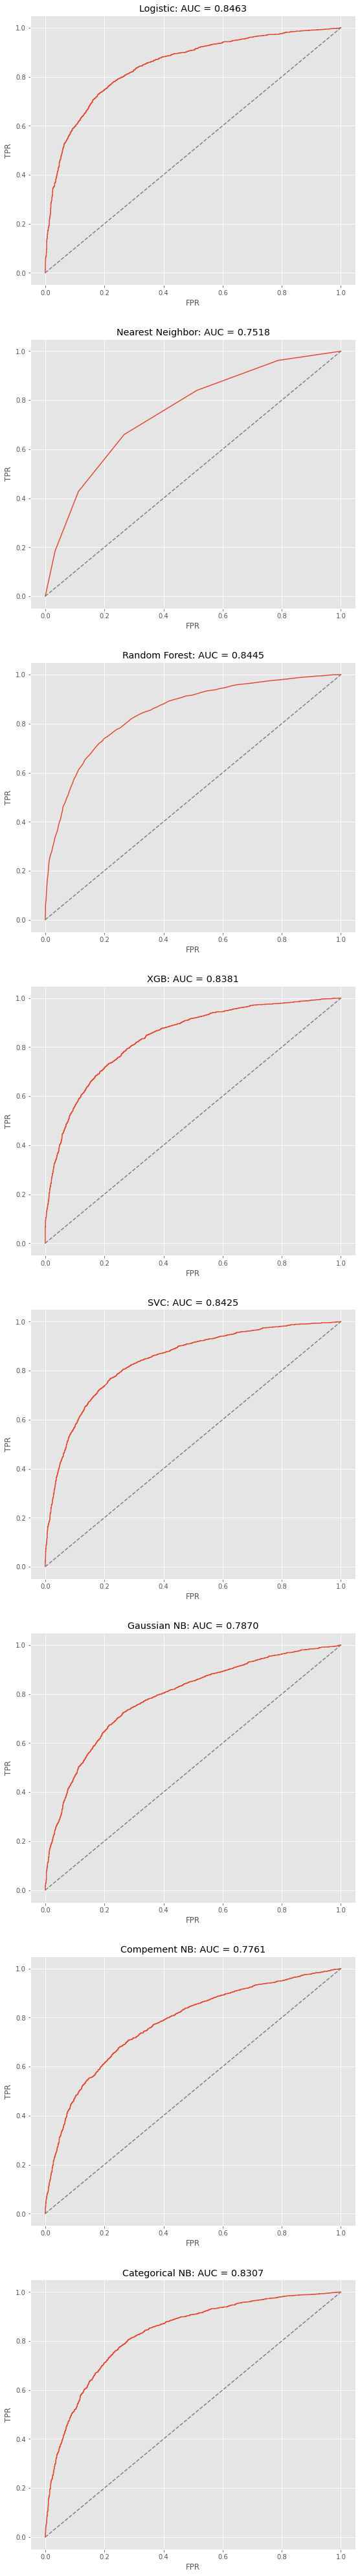

In [16]:
plot_classifier_rocs(X_train, X_eval, y_train, y_eval, classifier_list)

We see similar results here. Categorical Naive Bayes seems to be doing all right so I keep it. But the KNN and other Naive Bayes methods Im no longer looking at.

# Plot confusion for H1N1

In [17]:
def plot_confusion(y_true, y_score, label_name, ax):
    """
    A method that plots one confusion matrix
    Its takes in the y true and y predicted as well as a label name and an axis to graph on
    it graphs the confusion matrix on the corresponding ax
    """
    confusion = confusion_matrix(y_true, y_score)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',ax=ax,
               xticklabels=['No H1N1', 'Yes H1N1'],
               yticklabels=['No H1N1', 'Yes H1N1'])

    ax.set_ylabel('Predicted Visits')
    ax.set_xlabel('Actual Visits')
    ax.set_title(label_name);

In [18]:
def plot_classifier_confusions(X_train, X_eval, y_train, y_eval, classifier_list):
    """
    A method that plots multiple confusion matrixes for many models
    Its takes in x and y train and validate as well as a list of classifiers
    Spits out a confusion matrix for each model
    """
    fig, ax = plt.subplots(
            len(classifier_list), 1, figsize=(9,len(classifier_list)*9),
            dpi=100
        )

    for i, c_tup in enumerate(classifier_list):
        if len(classifier_list) == 1:
            ax_new=ax
        else:
            ax_new=ax[i]
            
        c = c_tup[0]
        c.fit(X_train, y_train)
        predict = c.predict(X_eval)
        plot_confusion(y_eval, predict, c_tup[1], ax_new);

In [19]:
# Lets trimp down our list of classifiers
classifier_list = [(logistic_regression, 'Logistic'), (rfc, 'Random Forest'), (xgb, 'XGB'), 
                   (svc, 'SVC'), (catnb, "Categorical NB")]

In [20]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

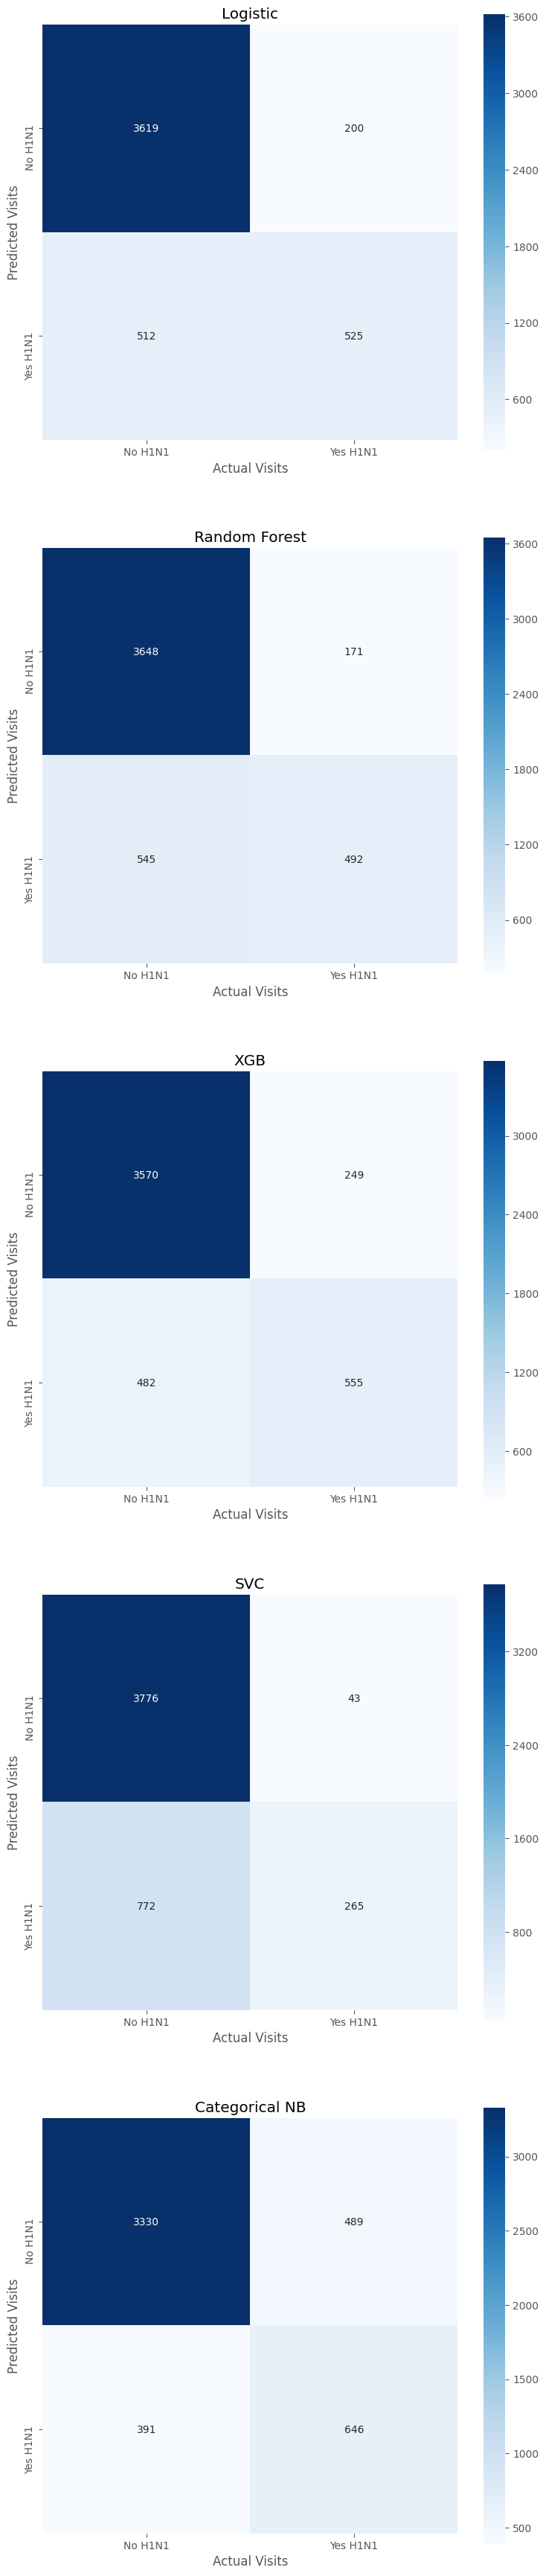

In [21]:
plot_classifier_confusions(X_train, X_eval, y_train, y_eval, classifier_list);

What Im really looking at is the "recall" for no vaccine (top right corner). This is the number of users who didnt get a vaccine that our model missed. Meaning that we won't flag them when we really should. 

SVC limits this recall the most, but in turn terrible accuracy. Looking at these plots I really like the Logistic, Random Forrest, and XGB.

# Plot confusion for Seasonal

In [22]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

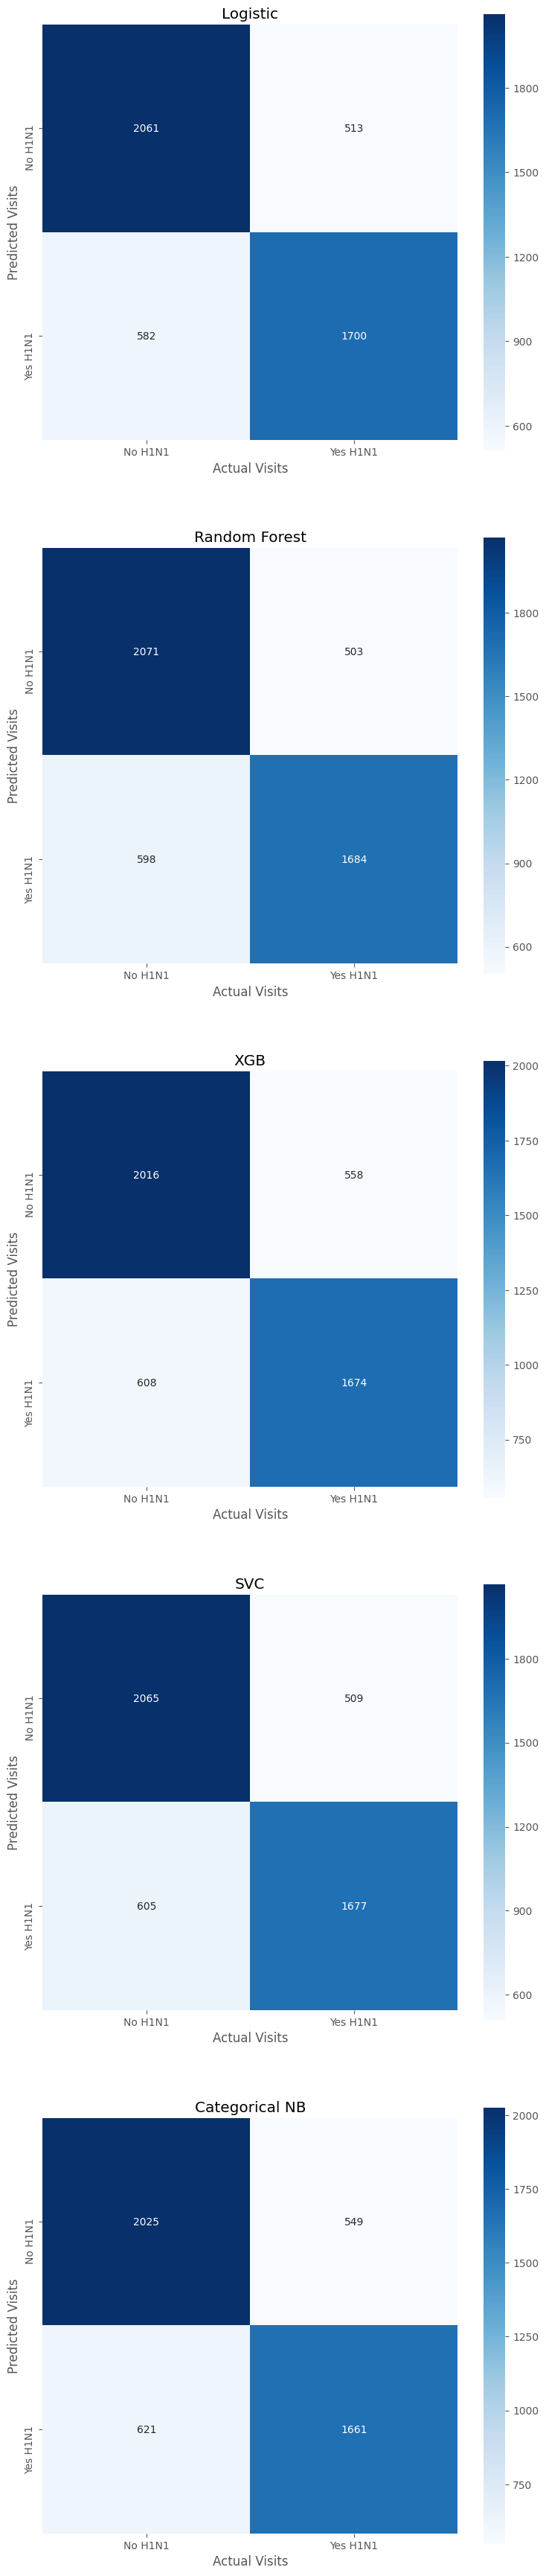

In [23]:
plot_classifier_confusions(X_train, X_eval, y_train, y_eval, classifier_list);

These all pretty much preformed the same

# Plot Scores H1N1
This is really the same as the confusion matrix, but gives us some real numbers

In [24]:
def plot_scores(X_train, y_train, X_eval, y_eval, classifier_list):
    """
    Takes in a train and val set and a list of classifires
    Returns a list of different score metrics
    """
    for c_tup in classifier_list:
        c = c_tup[0]
        c.fit(X_train, y_train)
        print(c_tup[1])
        print(classification_report(y_eval, c.predict(X_eval), target_names=["No H1N1", "Yes H1N1"]))
        print("\n \n")

In [25]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

In [26]:
plot_scores(X_train, y_train, X_eval, y_eval, classifier_list)

Logistic
              precision    recall  f1-score   support

     No H1N1       0.88      0.95      0.91      3819
    Yes H1N1       0.72      0.51      0.60      1037

    accuracy                           0.85      4856
   macro avg       0.80      0.73      0.75      4856
weighted avg       0.84      0.85      0.84      4856


 

Random Forest
              precision    recall  f1-score   support

     No H1N1       0.87      0.95      0.91      3819
    Yes H1N1       0.74      0.46      0.57      1037

    accuracy                           0.85      4856
   macro avg       0.80      0.71      0.74      4856
weighted avg       0.84      0.85      0.84      4856


 

XGB
              precision    recall  f1-score   support

     No H1N1       0.88      0.93      0.91      3819
    Yes H1N1       0.69      0.54      0.60      1037

    accuracy                           0.85      4856
   macro avg       0.79      0.73      0.76      4856
weighted avg       0.84      0.85      

So as we can see the SVC Recall for NO H1N1 is .99 (very good), but the recall for Yes is terrible. Logistic, XGB, and Random forrest are all pretty similar and all have a .85 accuracy. 

# Plot Scores Seasonal

In [27]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

In [28]:
plot_scores(X_train, y_train, X_eval, y_eval, classifier_list)

Logistic
              precision    recall  f1-score   support

     No H1N1       0.78      0.80      0.79      2574
    Yes H1N1       0.77      0.74      0.76      2282

    accuracy                           0.77      4856
   macro avg       0.77      0.77      0.77      4856
weighted avg       0.77      0.77      0.77      4856


 

Random Forest
              precision    recall  f1-score   support

     No H1N1       0.78      0.80      0.79      2574
    Yes H1N1       0.76      0.74      0.75      2282

    accuracy                           0.77      4856
   macro avg       0.77      0.77      0.77      4856
weighted avg       0.77      0.77      0.77      4856


 

XGB
              precision    recall  f1-score   support

     No H1N1       0.77      0.78      0.78      2574
    Yes H1N1       0.75      0.73      0.74      2282

    accuracy                           0.76      4856
   macro avg       0.76      0.76      0.76      4856
weighted avg       0.76      0.76      

They all preformed about the same for Seasonal.

# Feature Importance for H1N1

No lets look at feature importance using random forrest and lositic regression

In [29]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

In [30]:
rfc.fit(X_train, y_train);
rfc.feature_importances_
features_df.columns;

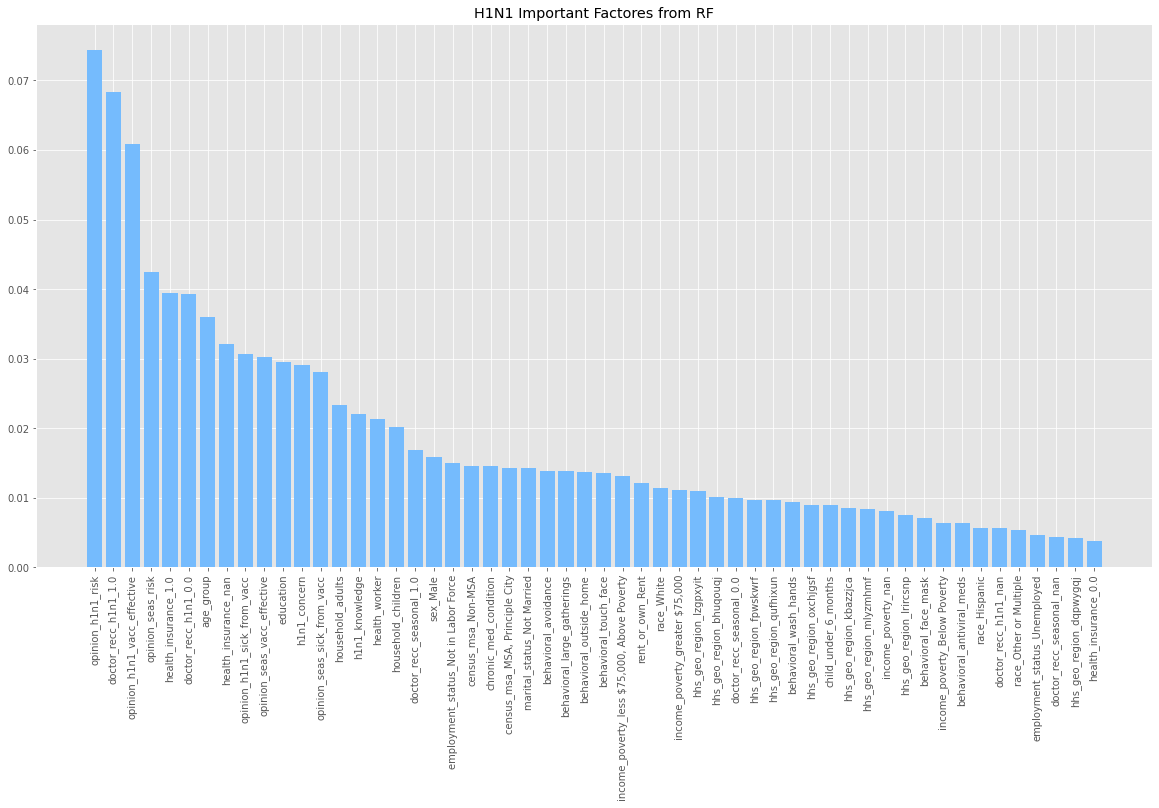

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('H1N1 Important Factores from RF')
for c in sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [32]:
logistic_regression.fit(X_train, y_train)
classifier = logistic_regression.named_steps['estimator']
classifier.coef_

array([[ 0.01079177,  0.11083667, -0.01031199, -0.04478743,  0.01693743,
         0.00510276, -0.07577829,  0.00836858,  0.02356923,  0.07982385,
         0.0748837 ,  0.30271689,  0.58955578,  0.55630388,  0.01961579,
         0.1409761 ,  0.1627513 , -0.10829289,  0.1245314 ,  0.10836515,
        -0.02964917, -0.04243124, -0.00967184,  0.41735118, -0.41624609,
        -0.37644919,  0.49168409, -0.11336595,  0.16546099, -0.10988254,
        -0.11336595, -0.02543619,  0.01090462,  0.0002305 ,  0.02397438,
         0.09303025,  0.09693502,  0.12710801,  0.08133328, -0.07743252,
         0.00254766,  0.06145455,  0.00086149, -0.05180852, -0.11633065,
        -0.0556972 , -0.03428556, -0.00533519, -0.08336836, -0.0082454 ,
         0.00176696, -0.01647041,  0.03057672,  0.05311289]])

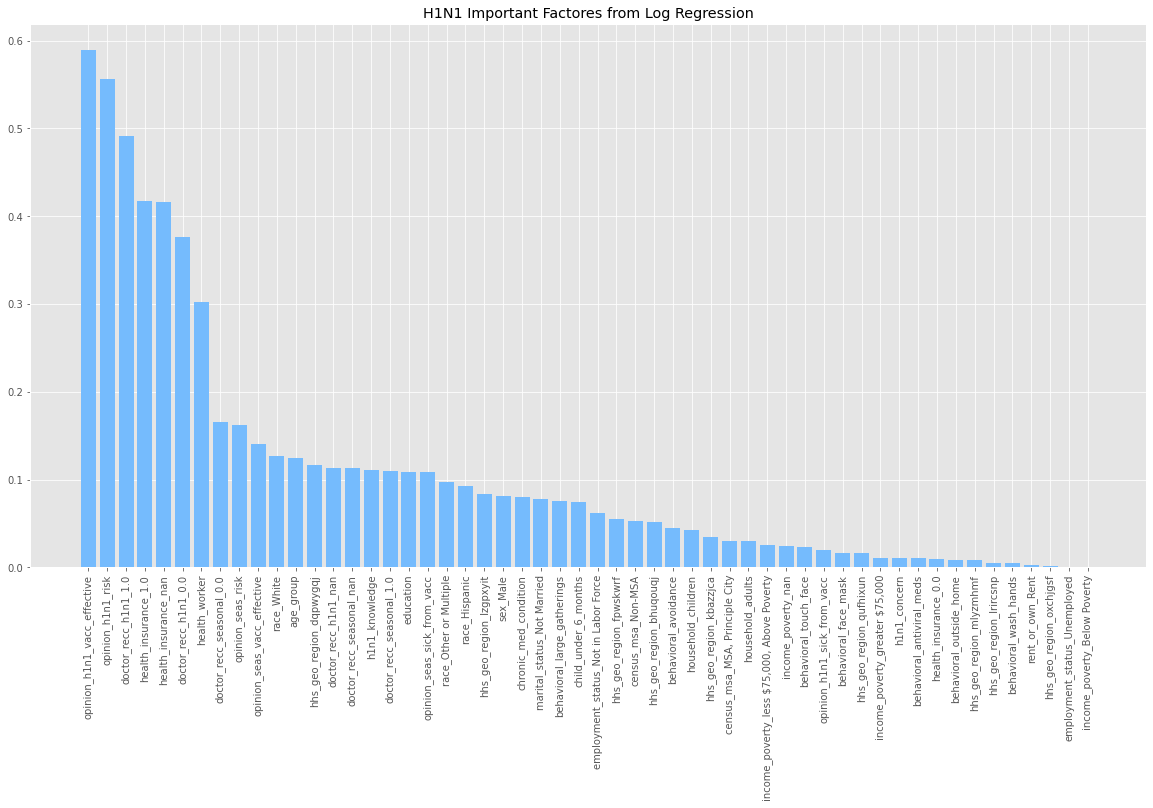

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('H1N1 Important Factores from Log Regression')
for c in sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [34]:
top_rf = sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True)[:15]
top_rf_cats = [x[1] for  x in top_rf]
top_rf_cats;

In [35]:
top_log = sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True)[:15]
top_log_cats = [x[1] for  x in top_log]
top_log_cats;

In [36]:
combined = [x for x in top_rf_cats if x in top_log_cats]
combined

['opinion_h1n1_risk',
 'doctor_recc_h1n1_1.0',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk',
 'health_insurance_1.0',
 'doctor_recc_h1n1_0.0',
 'age_group',
 'health_insurance_nan',
 'opinion_seas_vacc_effective']

This isn't exactly one to one, but it gives us a good idea of what features are important.
These are the top 9 features

# Feature Importance for Seasonal

Lets see whats important for the seasonal vaccine

In [37]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

In [38]:
rfc.fit(X_train, y_train);
rfc.feature_importances_

array([0.02885826, 0.02292332, 0.00537425, 0.012894  , 0.00600411,
       0.0097428 , 0.01357938, 0.01342492, 0.01395635, 0.01596505,
       0.00696797, 0.0158282 , 0.03467926, 0.03628574, 0.028984  ,
       0.0848086 , 0.09922963, 0.03131774, 0.06549503, 0.03029033,
       0.02448166, 0.02127705, 0.00649201, 0.0152286 , 0.01075124,
       0.00821541, 0.01354564, 0.00503317, 0.02579468, 0.05321303,
       0.0054755 , 0.01308908, 0.01171764, 0.00703324, 0.00798437,
       0.00547135, 0.00503743, 0.01134965, 0.01591436, 0.01434138,
       0.01279741, 0.01575894, 0.00573227, 0.00996976, 0.00449085,
       0.00971613, 0.00943464, 0.00830893, 0.01047129, 0.00725884,
       0.00996237, 0.00966241, 0.0142826 , 0.01409814])

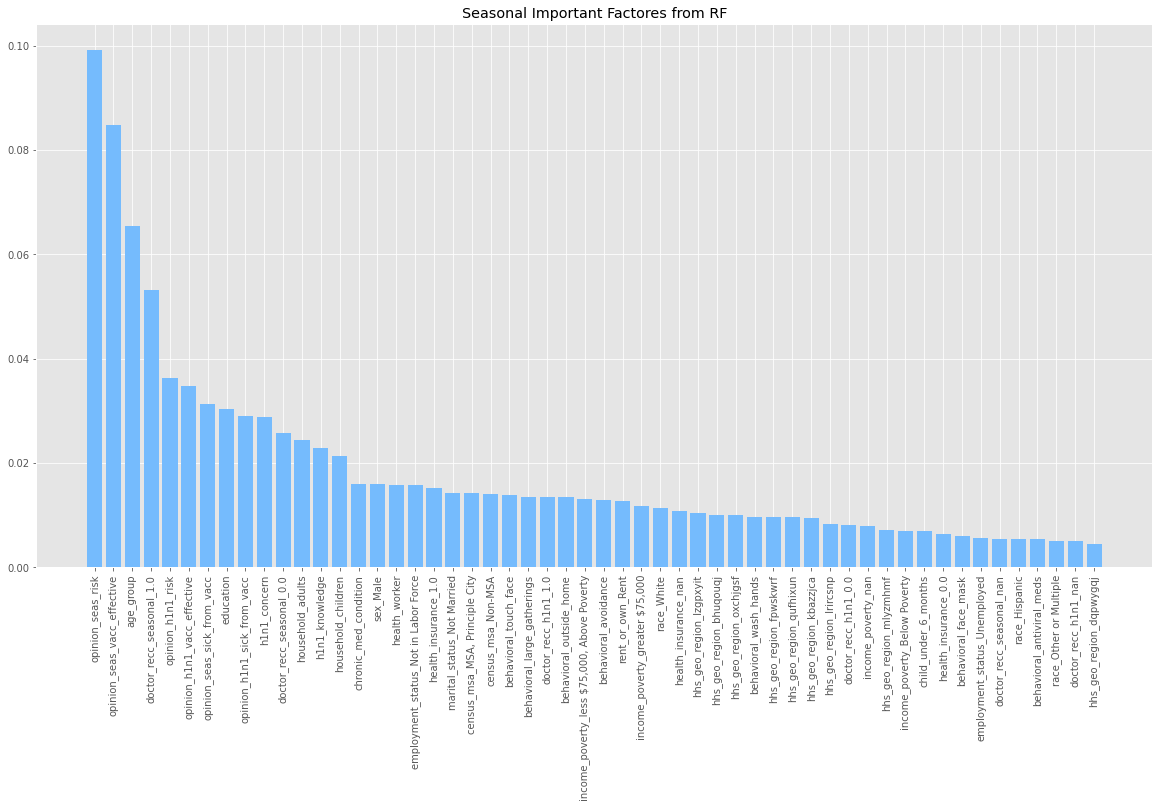

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('Seasonal Important Factores from RF')
for c in sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [40]:
logistic_regression.fit(X_train, y_train)
classifier = logistic_regression.named_steps['estimator']

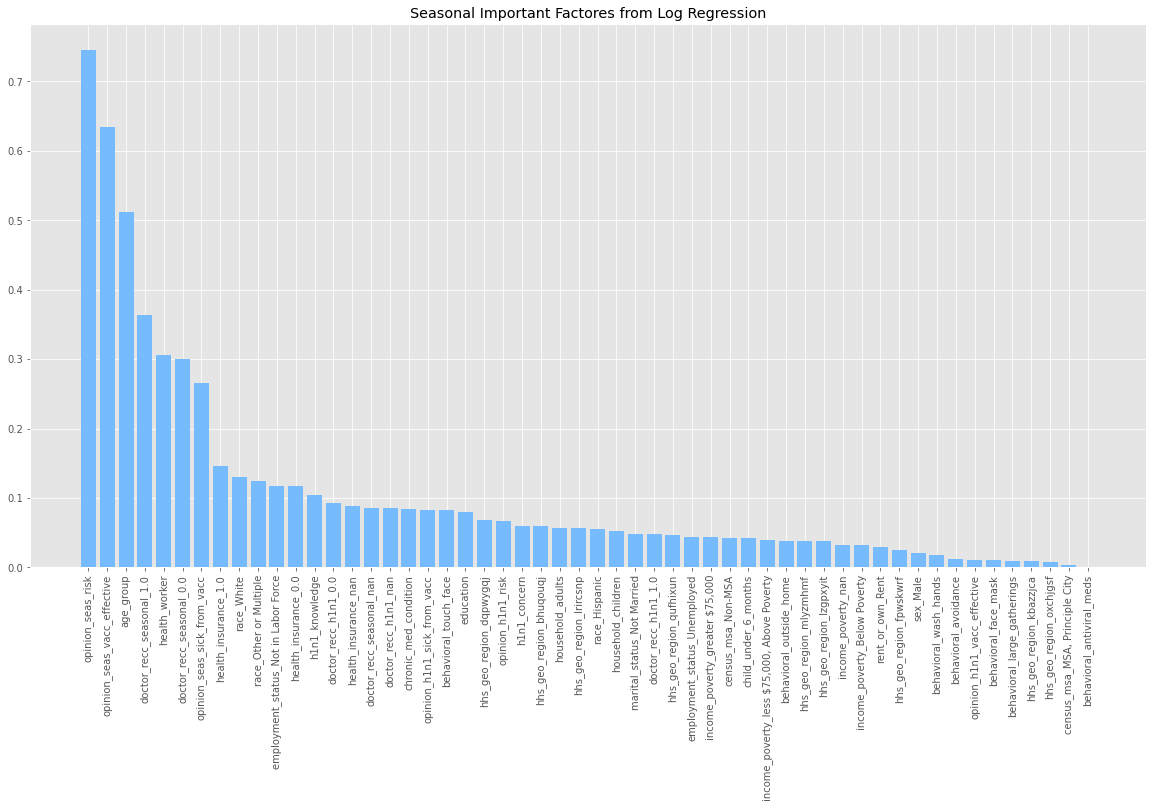

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('Seasonal Important Factores from Log Regression')
for c in sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [42]:
top_rf = sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True)[:15]
top_rf_cats = [x[1] for  x in top_rf]
top_rf_cats;

In [43]:
top_log = sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True)[:15]
top_log_cats = [x[1] for  x in top_log]
top_log_cats;

In [44]:
combined = [x for x in top_rf_cats if x in top_log_cats]
combined

['opinion_seas_risk',
 'opinion_seas_vacc_effective',
 'age_group',
 'doctor_recc_seasonal_1.0',
 'opinion_seas_sick_from_vacc',
 'doctor_recc_seasonal_0.0',
 'h1n1_knowledge']

# Over Sample

H1N1 is very imbalanced (80% No 20% yes). So lets over sample to see if that effects the model

In [45]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [46]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

In [47]:
len(X_train)

14568

In [48]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [49]:
len(X_smoted)

22912

In [50]:
y_smoted

0        0
1        0
2        0
3        0
4        0
        ..
22907    1
22908    1
22909    1
22910    1
22911    1
Name: h1n1_vaccine, Length: 22912, dtype: int64

In [51]:
sum(y_smoted)/len(y_smoted)

0.5

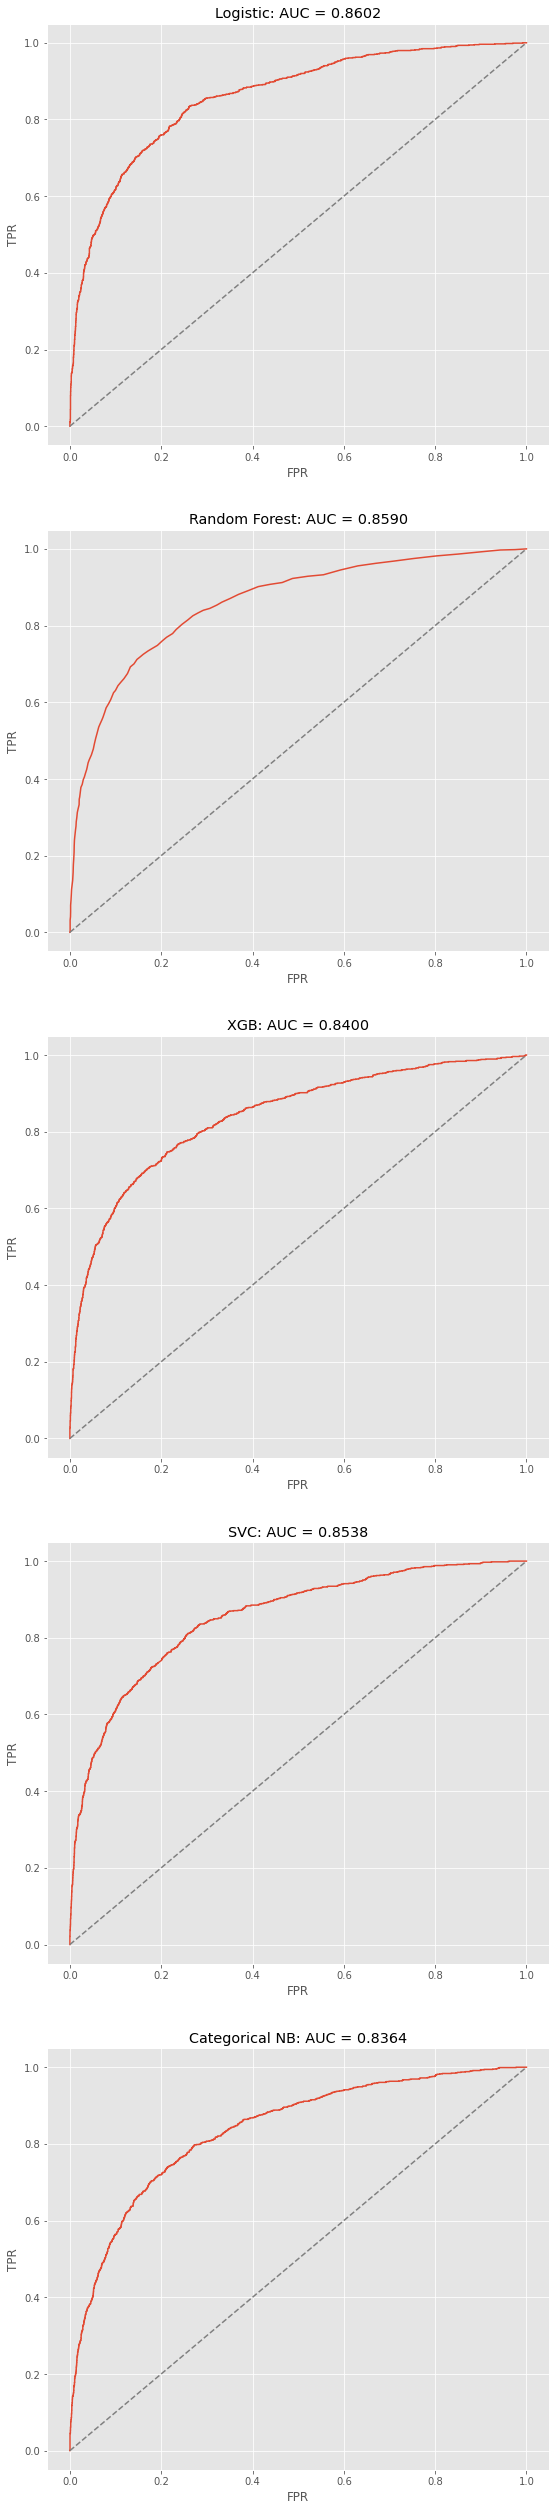

In [52]:
# plot just over sampled
plot_classifier_rocs(X_resampled, X_eval, y_resampled, y_eval, classifier_list)

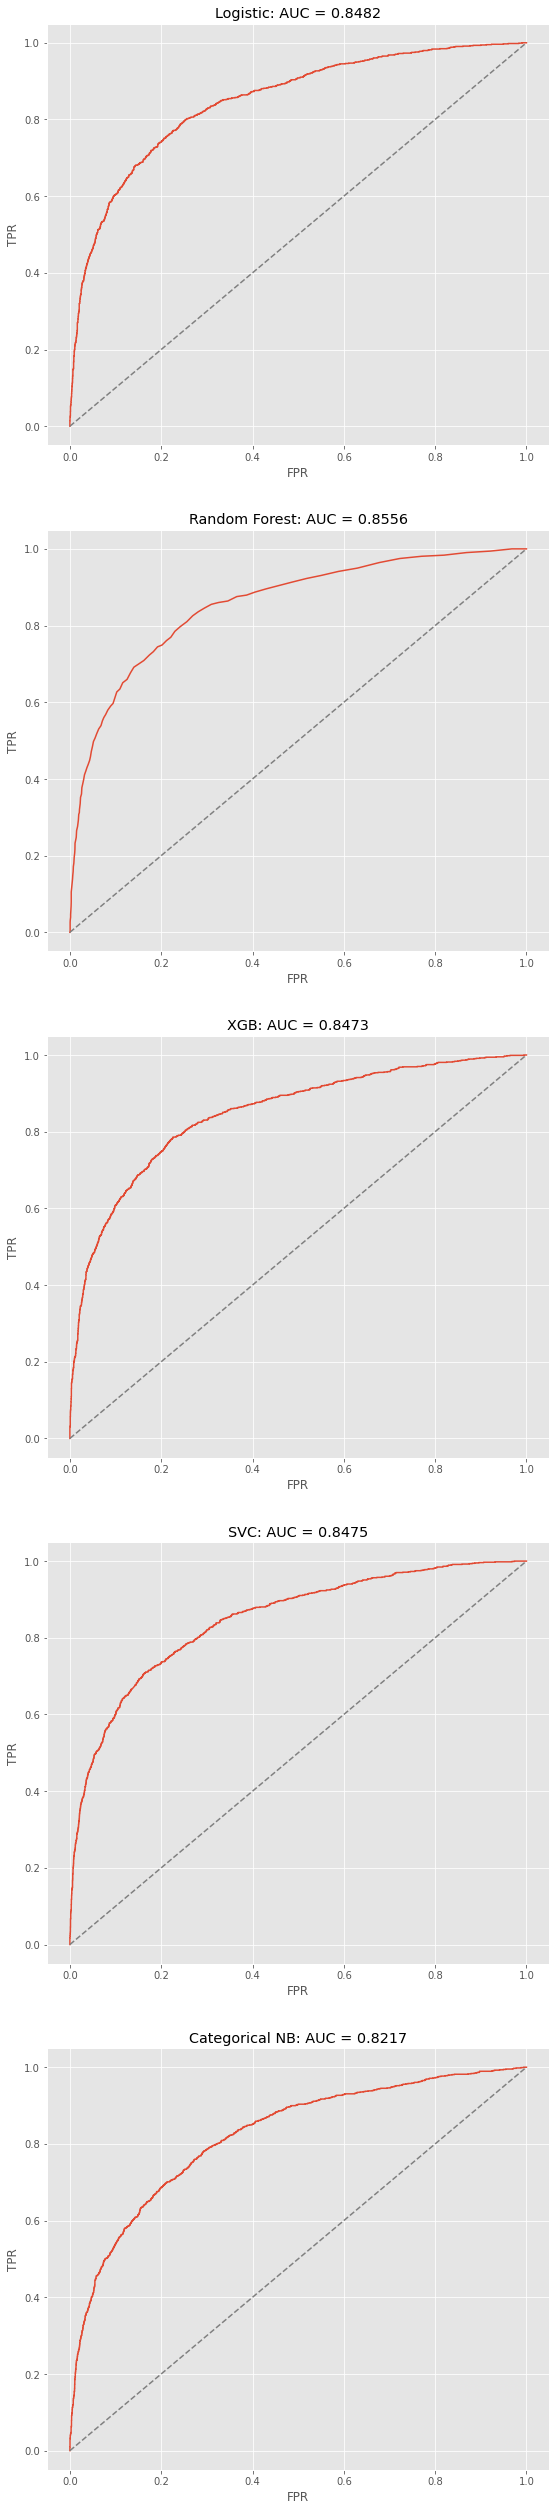

In [53]:
# Plot Smoted
plot_classifier_rocs(X_smoted, X_eval, y_smoted, y_eval, classifier_list)

In [54]:
plot_scores(X_resampled, y_resampled, X_eval, y_eval, classifier_list)

Logistic
              precision    recall  f1-score   support

     No H1N1       0.92      0.81      0.86      3819
    Yes H1N1       0.51      0.75      0.61      1037

    accuracy                           0.79      4856
   macro avg       0.72      0.78      0.73      4856
weighted avg       0.83      0.79      0.81      4856


 

Random Forest
              precision    recall  f1-score   support

     No H1N1       0.88      0.93      0.91      3819
    Yes H1N1       0.68      0.55      0.61      1037

    accuracy                           0.85      4856
   macro avg       0.78      0.74      0.76      4856
weighted avg       0.84      0.85      0.84      4856


 

XGB
              precision    recall  f1-score   support

     No H1N1       0.90      0.87      0.89      3819
    Yes H1N1       0.58      0.65      0.61      1037

    accuracy                           0.82      4856
   macro avg       0.74      0.76      0.75      4856
weighted avg       0.83      0.82      

In [55]:
plot_scores(X_smoted, y_smoted, X_eval, y_eval, classifier_list)

Logistic
              precision    recall  f1-score   support

     No H1N1       0.88      0.92      0.90      3819
    Yes H1N1       0.65      0.56      0.60      1037

    accuracy                           0.84      4856
   macro avg       0.77      0.74      0.75      4856
weighted avg       0.83      0.84      0.84      4856


 

Random Forest
              precision    recall  f1-score   support

     No H1N1       0.88      0.94      0.91      3819
    Yes H1N1       0.70      0.51      0.59      1037

    accuracy                           0.85      4856
   macro avg       0.79      0.73      0.75      4856
weighted avg       0.84      0.85      0.84      4856


 

XGB
              precision    recall  f1-score   support

     No H1N1       0.88      0.94      0.91      3819
    Yes H1N1       0.69      0.52      0.59      1037

    accuracy                           0.85      4856
   macro avg       0.78      0.73      0.75      4856
weighted avg       0.84      0.85      

So Smoting does work better than random over sampling. But the accuracy stays at .85 and the f1 scores are still around .9 and .6 for No and Yes respectively... so not really an improvement from before

# Ensemble

Lets ensemble some models now to see if this improves our score

I will use Random Forrest, Logistic regression, and XGB as these preformed the best. 


In [56]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

In [57]:
classifier_list = [('Logistic', logistic_regression), ('Random Forest', rfc), ('XGB', xgb)]

In [58]:
voting_model = VotingClassifier(estimators=classifier_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)

In [59]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [60]:
voting_model.fit(X_smoted, y_smoted)

VotingClassifier(estimators=[('Logistic',
                              Pipeline(steps=[('standard_scaler',
                                               StandardScaler()),
                                              ('estimator',
                                               LogisticRegression(C=1))])),
                             ('Random Forest', RandomForestClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
  

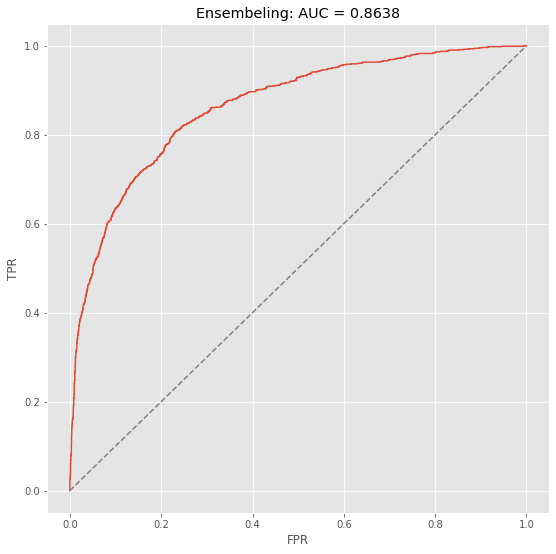

In [61]:
plot_classifier_rocs(X_resampled, X_eval, y_resampled, y_eval, [(voting_model, 'Ensembeling')])

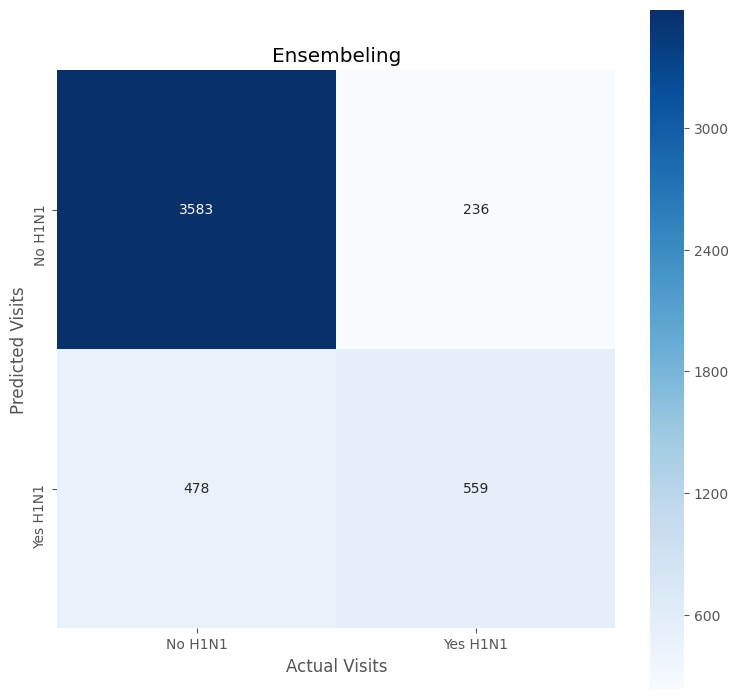

In [62]:
plot_classifier_confusions(X_smoted, X_eval, y_smoted, y_eval, [(voting_model, 'Ensembeling')])

In [63]:
voting_model_hard = VotingClassifier(estimators=classifier_list,
                                    voting='hard', #<-- sklearn calls this soft voting
                                    n_jobs=-1)

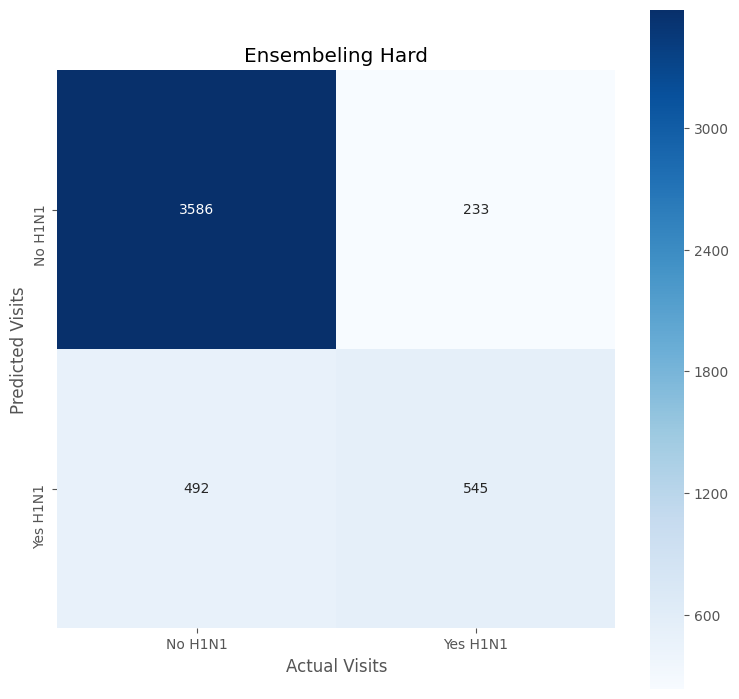

In [64]:
plot_classifier_confusions(X_smoted, X_eval, y_smoted, y_eval, [(voting_model_hard, 'Ensembeling Hard')])

In [65]:
plot_scores(X_smoted, y_smoted, X_eval, y_eval, [(voting_model_hard, 'Ensembeling Hard')])

Ensembeling Hard
              precision    recall  f1-score   support

     No H1N1       0.88      0.94      0.91      3819
    Yes H1N1       0.70      0.52      0.60      1037

    accuracy                           0.85      4856
   macro avg       0.79      0.73      0.75      4856
weighted avg       0.84      0.85      0.84      4856


 



# Best model for H1N1 is Ensemble with over Smote sampling

In [66]:
classifier_list = [('Logistic', logistic_regression), ('Random Forest', rfc), ('XGB', xgb)]

In [67]:
voting_model_soft = VotingClassifier(estimators=classifier_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)

In [68]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [69]:
voting_model_soft.fit(X_smoted, y_smoted);

In [70]:
print(classification_report(y_eval, voting_model_soft.predict(X_eval), target_names=["No H1N1", "Yes H1N1"]))

              precision    recall  f1-score   support

     No H1N1       0.88      0.94      0.91      3819
    Yes H1N1       0.70      0.54      0.61      1037

    accuracy                           0.85      4856
   macro avg       0.79      0.74      0.76      4856
weighted avg       0.84      0.85      0.85      4856



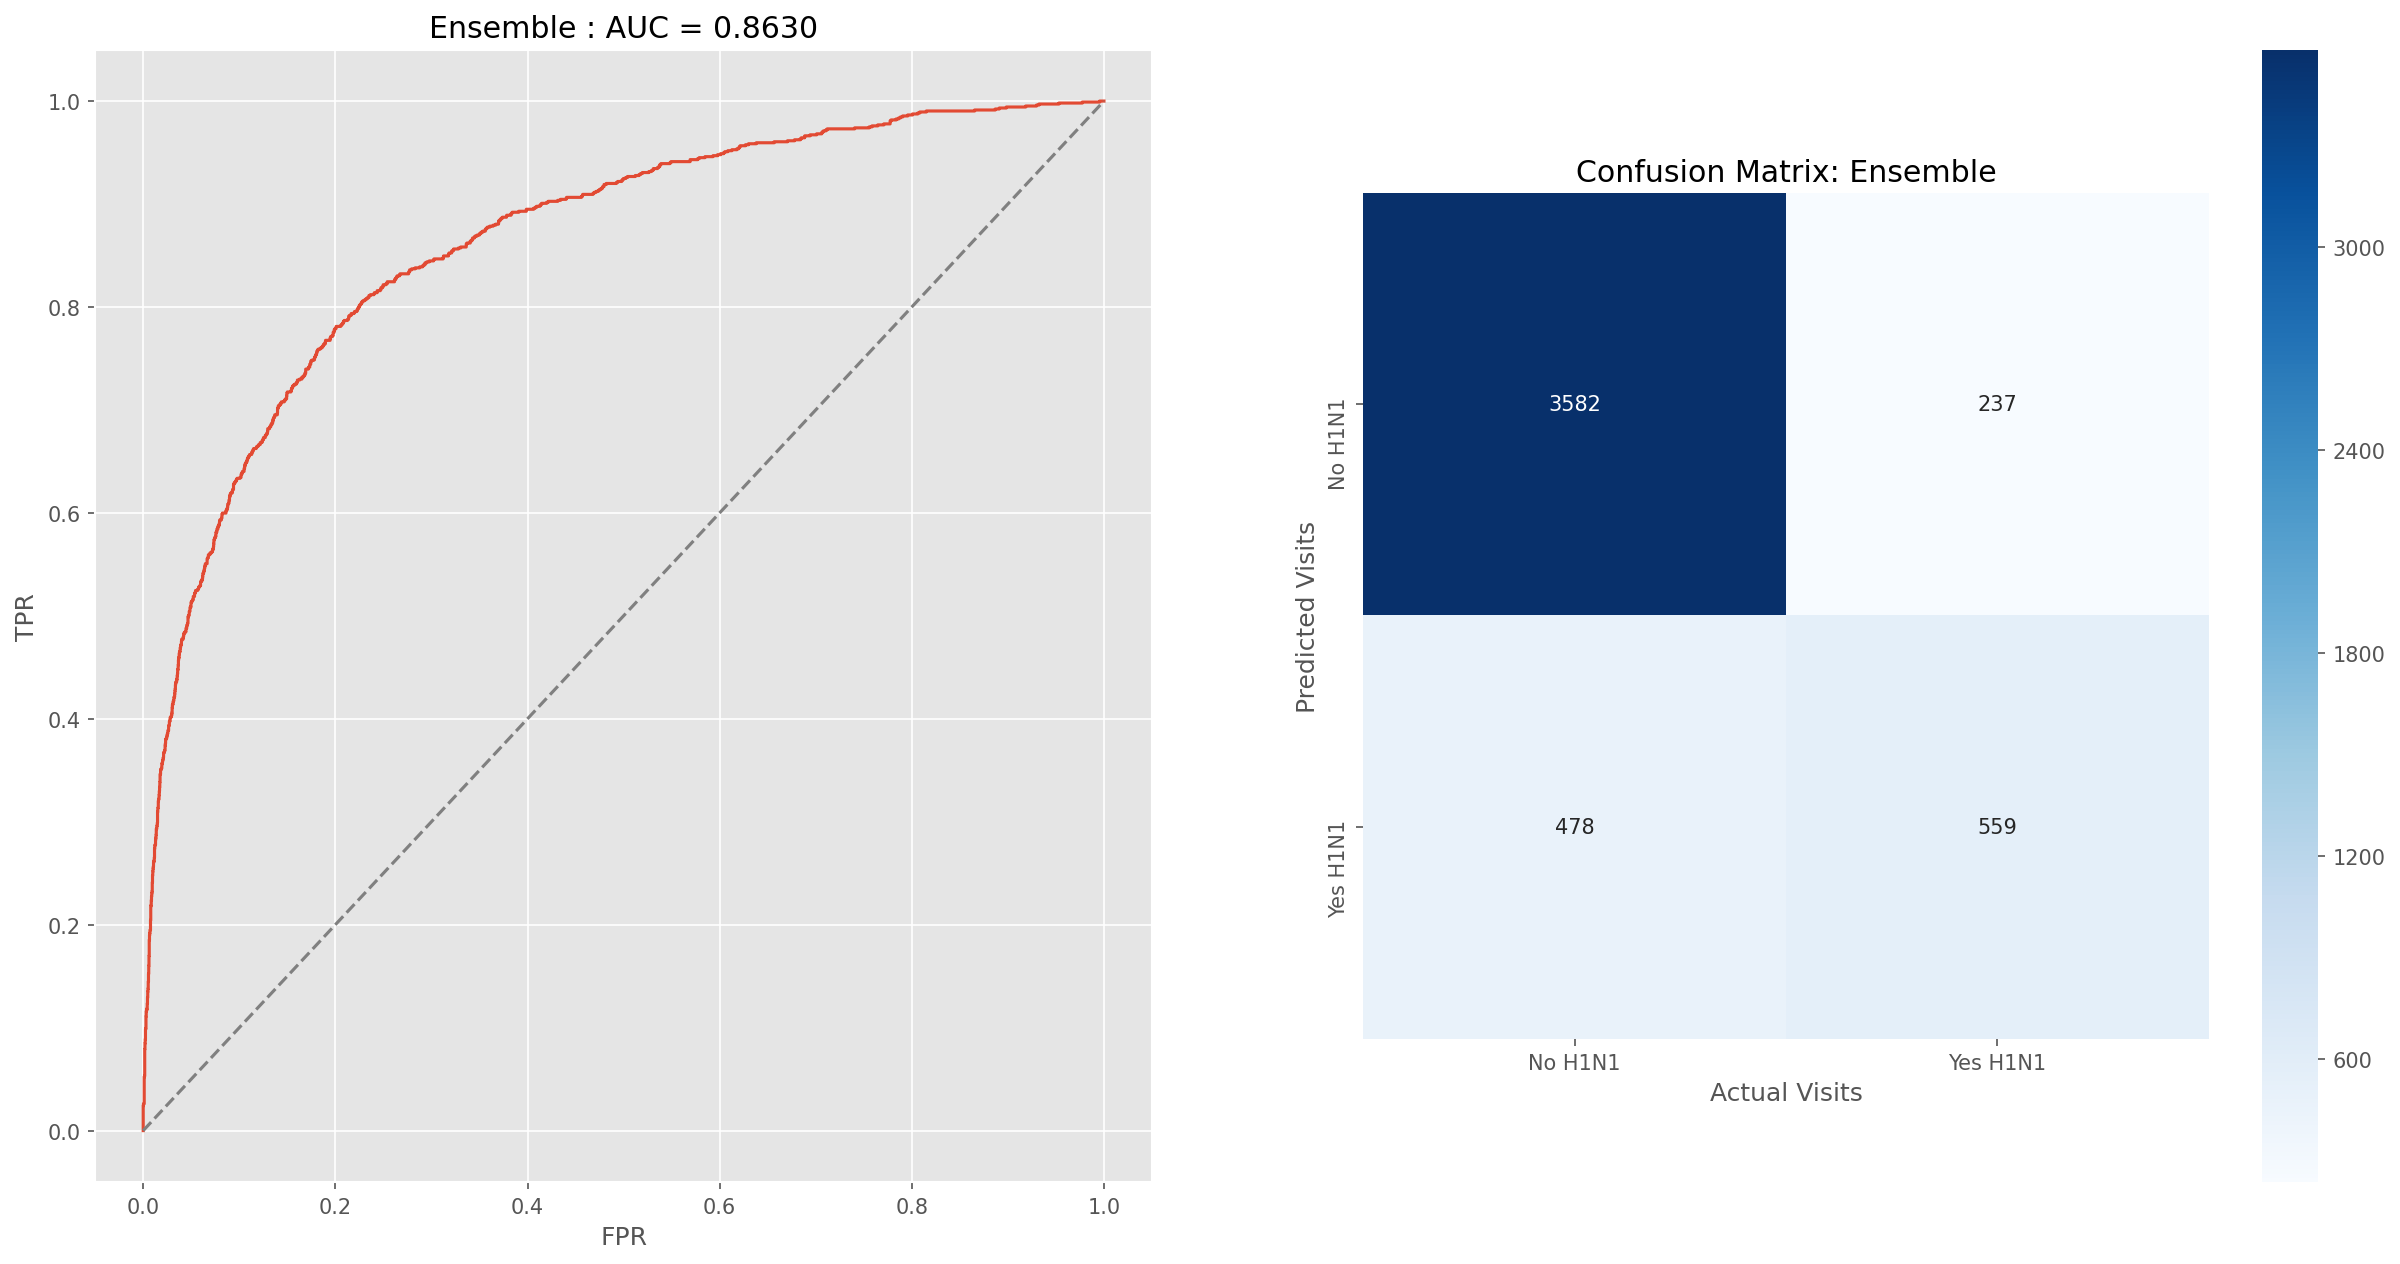

In [87]:
fig, ax = plt.subplots(
        1, 2, figsize=(20,10), dpi=150
    )
plot_roc(y_eval, voting_model_soft.predict_proba(X_eval)[:,1], "Ensemble ", ax[0])

confusion = confusion_matrix(y_eval, voting_model_soft.predict(X_eval))
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',ax=ax[1],
           xticklabels=['No H1N1', 'Yes H1N1'],
           yticklabels=['No H1N1', 'Yes H1N1'])

ax[1].set_ylabel('Predicted Visits')
ax[1].set_xlabel('Actual Visits')
ax[1].set_title("Confusion Matrix: Ensemble")
plt.savefig('ensemble_breakdown.png');

This is the best model, but it doesnt really preform any better than a classic Random Forrest and its much more complicated and time intensive. So for my Web app im using a RF model.

# combine models into one for app
We will use Random Forest for the app because it is less complex

In [72]:
from sklearn.multioutput import MultiOutputClassifier

In [73]:
rfc = RandomForestClassifier()

In [74]:
combined_model = MultiOutputClassifier(
    estimator=rfc
)

In [75]:
combined_model.fit(features_df, combined_targets);


In [76]:
features_ho_df = ho_df.drop(labels=['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis = 1)
combined_ho_targets = ho_df[['h1n1_vaccine', 'seasonal_vaccine']]

In [77]:
preds = combined_model.predict_proba(features_ho_df)

In [78]:
preds_1 = preds[0][:,1]
preds_2 = preds[1][:,1]
preds_2.shape

(4856,)

In [85]:
filename = "combined_model_2.pkl"

In [86]:
pickle.dump(combined_model, open(filename, 'wb'))

In [81]:
y_1 = combined_ho_targets['h1n1_vaccine']
y_2 = combined_ho_targets['seasonal_vaccine']
y_1.shape

(4856,)

In [82]:
h1n1_auc = roc_auc_score(y_1, preds_1)

In [83]:
seasonal_auc = roc_auc_score(y_2, preds_2)

In [84]:
(h1n1_auc + seasonal_auc)/2

0.8579484224371683

# Logistic Regression for app
Actually I am using Logistic regression for my app as the scores were basically the same, but the size of a pickled Logistic regression model is about a tenth of the size of randome forest.

In [88]:
logistic_regression = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('estimator', LogisticRegression(penalty="l2", C=1))
])


In [89]:
combined_model = MultiOutputClassifier(
    estimator=logistic_regression
)

In [90]:
combined_model.fit(features_df, combined_targets);

In [91]:
features_ho_df = ho_df.drop(labels=['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis = 1)
combined_ho_targets = ho_df[['h1n1_vaccine', 'seasonal_vaccine']]

In [92]:
preds = combined_model.predict_proba(features_ho_df)

In [93]:
preds_1 = preds[0][:,1]
preds_2 = preds[1][:,1]
preds_2.shape

(4856,)

In [94]:
filename = "combined_model_lr.pkl"

In [95]:
y_1 = combined_ho_targets['h1n1_vaccine']
y_2 = combined_ho_targets['seasonal_vaccine']
y_1.shape

(4856,)

In [96]:
h1n1_auc = roc_auc_score(y_1, preds_1)

In [97]:
seasonal_auc = roc_auc_score(y_2, preds_2)

In [98]:
(h1n1_auc + seasonal_auc)/2

0.8566947872396625

In [99]:
pickle.dump(combined_model, open(filename, 'wb'))